In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2, os

In [ ]:
! mkdir -p /root/.kaggle
! mv kaggle.json /root/.kaggle

In [ ]:
import kaggle

In [ ]:
! kaggle competitions download -c dog-breed-identification

 98% 679M/691M [00:05<00:00, 156MB/s]
100% 691M/691M [00:05<00:00, 122MB/s]


In [ ]:
! unzip -q dog-breed-identification.zip

In [ ]:
! rm -rf test sample_submission.csv

In [ ]:
# files in train folder
len(os.listdir("train"))

10222

In [ ]:
os.listdir("train")[:10]

['73fe2b31f6e54846d580e36ecfe54007.jpg',
 '1b801c3bdbb2c85e30cbefb641878005.jpg',
 '5048b8f64705a33e21eef80da4711c9c.jpg',
 '5d1b4ea2e14208ed4523f80bba2f015f.jpg',
 'f6bdbf94ffea753f4f7638784faf01cc.jpg',
 'a5545758fa85ed04ac848736e0eea7c0.jpg',
 '53ead8dd8986fbb0986c8e0cf2dd45f5.jpg',
 'a09920def5c696a562a2dd7ca6feedc5.jpg',
 '871477f33574a10e01a0b5b625f35b63.jpg',
 '6fd91d9b93604a4b156662fb1d763d29.jpg']

In [ ]:
df = pd.read_csv("labels.csv")
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
df.breed.nunique()

120

In [ ]:
df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [ ]:
# df.groupby("breed").size()

<Axes: >

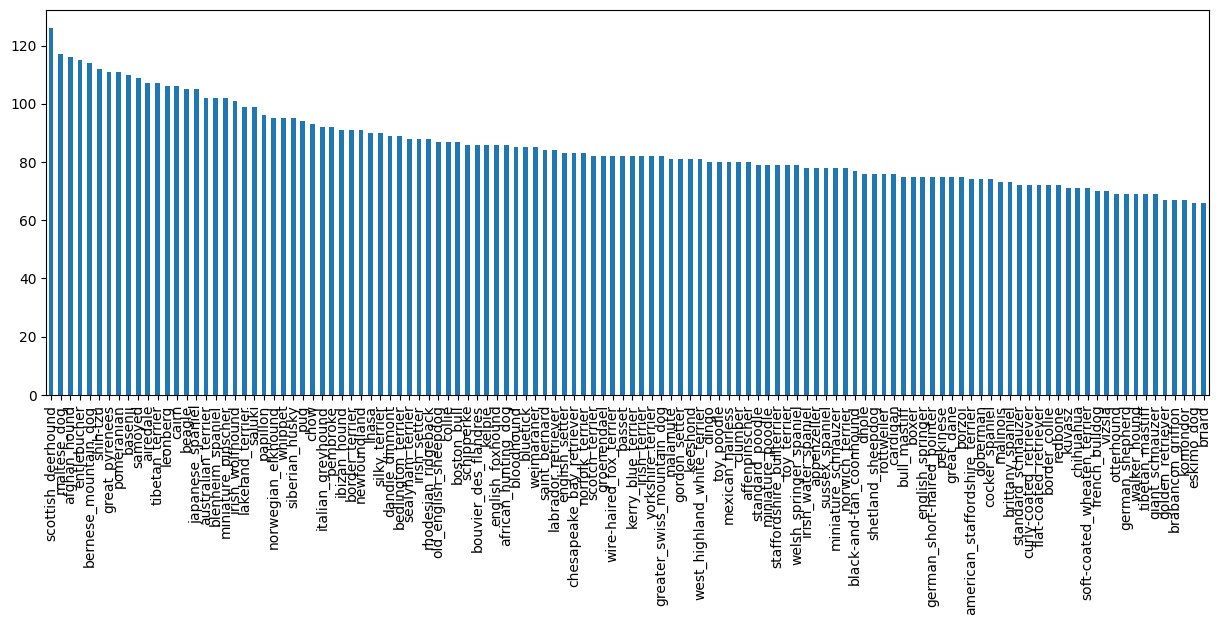

In [ ]:
plt.figure(figsize=(15, 5))
df.breed.value_counts().plot.bar()

In [ ]:
# Dog Vs Cats 25000 & 2 category (12500 images for each category)
# Dog Breed 10222 & 120 category (~85 images for each category)

In [ ]:
# Class Imbalance ...

## Solutions -
# 1. Augumentation
# 2. Group smaller category


# Q -
# 1. Upsampling by augumentation ... https://imgaug.readthedocs.io/en/latest/
# 2. Grouping small category

In [ ]:
vgg_full = tf.keras.applications.VGG16()

553467096/553467096 [==============================] - 2s 0us/step


In [ ]:
vgg_full.input_shape

(None, 224, 224, 3)

In [ ]:
# Read Image -
test_image = cv2.imread("train/000bec180eb18c7604dcecc8fe0dba07.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (224, 224))
test_image = tf.keras.applications.vgg16.preprocess_input(test_image)
test_image = np.expand_dims(test_image,axis=0)

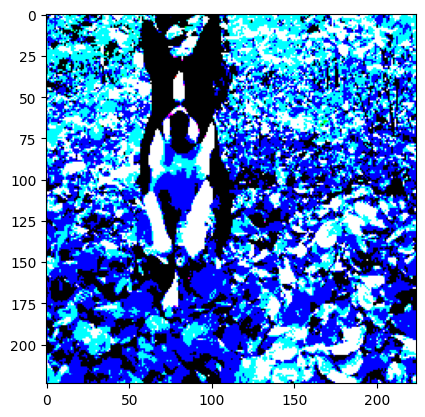

In [ ]:
plt.imshow(test_image[0])

In [ ]:
result = vgg_full.predict(test_image)
# result

1/1 [==============================] - 9s 9s/step


In [ ]:
tf.keras.applications.vgg16.decode_predictions(result)

35363/35363 [==============================] - 0s 0us/step


[[('n02096585', 'Boston_bull', 0.65559465),
  ('n02087046', 'toy_terrier', 0.21874641),
  ('n02085620', 'Chihuahua', 0.07683263),
  ('n02108915', 'French_bulldog', 0.014235259),
  ('n02113186', 'Cardigan', 0.008752351)]]

In [ ]:
# Try to predict all images using VGG

In [ ]:
df["id"] = df["id"] + ".jpg"

In [ ]:
df.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [ ]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
gen = idg.flow_from_dataframe(df, directory="train/", x_col = 'id', y_col="breed",
                              target_size=(224, 224), batch_size=32, shuffle=False)

Found 10222 validated image filenames belonging to 120 classes.


In [ ]:
results = vgg_full.predict(gen)

320/320 [==============================] - 41s 127ms/step


In [ ]:
results.shape

(10222, 1000)

In [ ]:
results_top1 = tf.keras.applications.vgg16.decode_predictions(results, top=1)

In [ ]:
for i in zip(df["id"], results_top1):
  print(i)
  print(i[0][1])
  print(i[0][2])
  break

[('n02096585', 'Boston_bull', 0.48772186)]
Boston_bull
0.48772186


In [ ]:
# p1 - 34, p2 - 23, p3 - 76
products = ["p1", "p2", 'p3']
prices   = [34, 23, 76]
countries = ["IN", "US", "UK"]
for price, product, country in zip(prices, products, countries):
  print(product, price, country)

p1 34 IN
p2 23 US
p3 76 UK


In [ ]:
df_2 = pd.DataFrame()
df_2["id"] = None
df_2["pred_cat"] = None
df_2["pred_prob"] = None
id = []
pred_cat = []
pred_prob = []
for image, result in zip(df["id"], results_top1):
  id.append(image)
  pred_cat.append(result[0][1])
  pred_prob.append(result[0][2])
df_2["id"] = id
df_2["pred_cat"] = pred_cat
df_2["pred_prob"] = pred_prob

In [ ]:
df_2.head()

,id,pred_cat,pred_prob
0,000bec180eb18c7604dcecc8fe0dba07.jpg,Boston_bull,0.487722
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,0.517894
2,001cdf01b096e06d78e9e5112d419397.jpg,Shih-Tzu,0.384243
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,0.787850
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,Labrador_retriever,0.255834


In [ ]:
df_3 = pd.merge(df, df_2, on="id")

In [ ]:
df_3.head()

,id,breed,pred_cat,pred_prob
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull,Boston_bull,0.487722
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,dingo,0.517894
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese,Shih-Tzu,0.384243
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,bluetick,0.787850
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,Labrador_retriever,0.255834


In [ ]:
df_3.columns = ["id", "actual_cat", "pred_cat", "pred_prob"]

In [ ]:
df_3.head()

,id,actual_cat,pred_cat,pred_prob
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull,Boston_bull,0.487722
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,dingo,0.517894
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese,Shih-Tzu,0.384243
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,bluetick,0.787850
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,Labrador_retriever,0.255834


In [ ]:
df_3["pred_cat"] = df_3["pred_cat"].str.lower()

In [ ]:
df_3.head()

,id,actual_cat,pred_cat,pred_prob
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull,boston_bull,0.487722
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo,dingo,0.517894
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese,shih-tzu,0.384243
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick,bluetick,0.787850
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,labrador_retriever,0.255834


In [ ]:
df_3.loc[df_3.actual_cat == df_3.pred_cat].shape[0]

7591

In [ ]:
df_3.loc[df_3.actual_cat == df_3.pred_cat].sort_values("pred_prob", ascending=False)

,id,actual_cat,pred_cat,pred_prob
4964,7ce17dea4ab0b5b9b2ac9dc9fcf3446f.jpg,mexican_hairless,mexican_hairless,1.000000
9916,f90e5fa3f7dabd3292fecf4312ba98c4.jpg,komondor,komondor,1.000000
377,09288e5c39391b780412561163b10bf5.jpg,afghan_hound,afghan_hound,1.000000
7485,bbdf0182c894bda733805993317a6e3d.jpg,komondor,komondor,1.000000
5312,85bfb0ee0c6071dcafd54d343a64a5d5.jpg,saint_bernard,saint_bernard,1.000000
...,...,...,...,...
6086,99b0f0ff409732318fbf7d2cf8c8d01c.jpg,english_springer,english_springer,0.098419
1453,243a801532ba613be030c802954b580c.jpg,ibizan_hound,ibizan_hound,0.092069
9160,e620a0807519a406a20dbe50ebeb1b1c.jpg,italian_greyhound,italian_greyhound,0.078052
7535,bced88130af56fd6d8ae65564e3dbaba.jpg,toy_terrier,toy_terrier,0.072842


In [ ]:
7591/10222 * 100

74.26139698689101

In [ ]:
df_3.loc[df_3.actual_cat != df_3.pred_cat]

,id,actual_cat,pred_cat,pred_prob
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese,shih-tzu,0.384243
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,labrador_retriever,0.255834
5,002211c81b498ef88e1b40b9abf84e1d.jpg,bedlington_terrier,soft-coated_wheaten_terrier,0.288631
6,00290d3e1fdd27226ba27a8ce248ce85.jpg,bedlington_terrier,wire-haired_fox_terrier,0.566125
11,0067dc3eab0b3c3ef0439477624d85d6.jpg,walker_hound,english_foxhound,0.480611
...,...,...,...,...
10206,ffa16727a9ee462ee3f386be865b199e.jpg,irish_wolfhound,scottish_deerhound,0.518447
10212,ffc532991d3cd7880d27a449ed1c4770.jpg,tibetan_terrier,otterhound,0.584490
10216,ffcffab7e4beef9a9b8076ef2ca51909.jpg,samoyed,great_pyrenees,0.863982
10218,ffd3f636f7f379c51ba3648a9ff8254f.jpg,dandie_dinmont,lakeland_terrier,0.417954


In [ ]:
df_3.actual_cat.nunique()

120

In [ ]:
df_3.pred_cat.nunique()

262

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
cm = confusion_matrix(df_3.actual_cat, y_pred = df_3.pred_cat)

In [ ]:
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(y_true = df_3.actual_cat, y_pred = df_3.pred_cat, ))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                precision    recall  f1-score   support

                 affenpinscher       0.93      0.71      0.81        80
                  afghan_hound       0.80      0.85      0.83       116
           african_hunting_dog       0.99      0.84      0.91        86
                      airedale       0.56      0.86      0.68       107
                           alp       0.00      0.00      0.00         0
                         altar       0.00      0.00      0.00         0
           american_black_bear       0.00      0.00      0.00         0
american_staffordshire_terrier       0.62      0.54      0.58        74
                        angora       0.00      0.00      0.00         0
                   appenzeller       0.45      0.37      0.41        78
                 arabian_camel       0.00      0.00      0.00         0
                    arctic_fox       0.00      0.00      0.00         0
            australian_terrier       0.68      0.68      0.68  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_3.loc[df_3.pred_cat == "bathtub"]

,id,actual_cat,pred_cat,pred_prob
5146,82052dbdc6378944f3269b8b5507f11d.jpg,cocker_spaniel,bathtub,0.544848
5791,925b2891c064453b9b2b94cd4e0d6307.jpg,shih-tzu,bathtub,0.354376


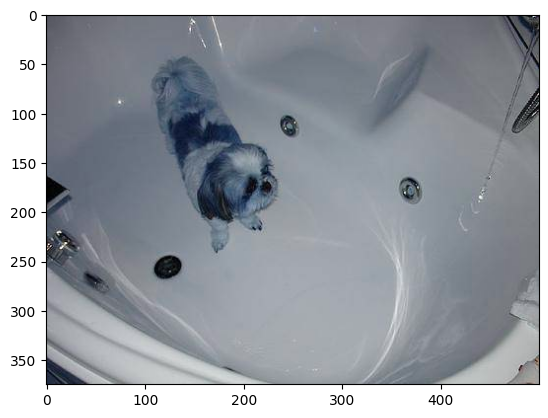

In [ ]:
plt.imshow(cv2.imread("train/925b2891c064453b9b2b94cd4e0d6307.jpg"))

In [ ]:
# VGG (Conv) + Cat Layer ==>

In [ ]:
# 1. Download the VGG but with its cat layer
# 2. We should append our own cat layers
# 3. Make a final model and pass Image Gen

In [ ]:
# Download the headless VGG with 224,224 images -
vgg_notop = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_notop.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Freeze the VGG
for layer in vgg_notop.layers:
  layer.trainable = False

In [ ]:
# Functional Model
# layer = tf.keras.layers.LAYERXYZ (previous_layer_name)

flat   = tf.keras.layers.Flatten(name="Flat") (vgg_notop.output)
dense1 = tf.keras.layers.Dense(1024, activation="relu", name="dense1") (flat)
dense2 = tf.keras.layers.Dense(512, activation="relu", name='dense2') (dense1)
output = tf.keras.layers.Dense(120, activation='softmax', name='output') (dense2)

In [ ]:
final_model = tf.keras.models.Model(inputs=[vgg_notop.input], outputs=[output])

In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
idg2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split= 0.1)

In [ ]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [ ]:
batch_size = 64
train_idg = idg2.flow_from_dataframe(df, "train/", x_col="id", y_col= "breed",
                                     target_size = (224, 224), batch_size = batch_size,
                                     subset="training")
val_idg   = idg2.flow_from_dataframe(df, "train/", x_col="id", y_col="breed",
                                     target_size = (224, 224), batch_size = batch_size,
                                     subset="validation")

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


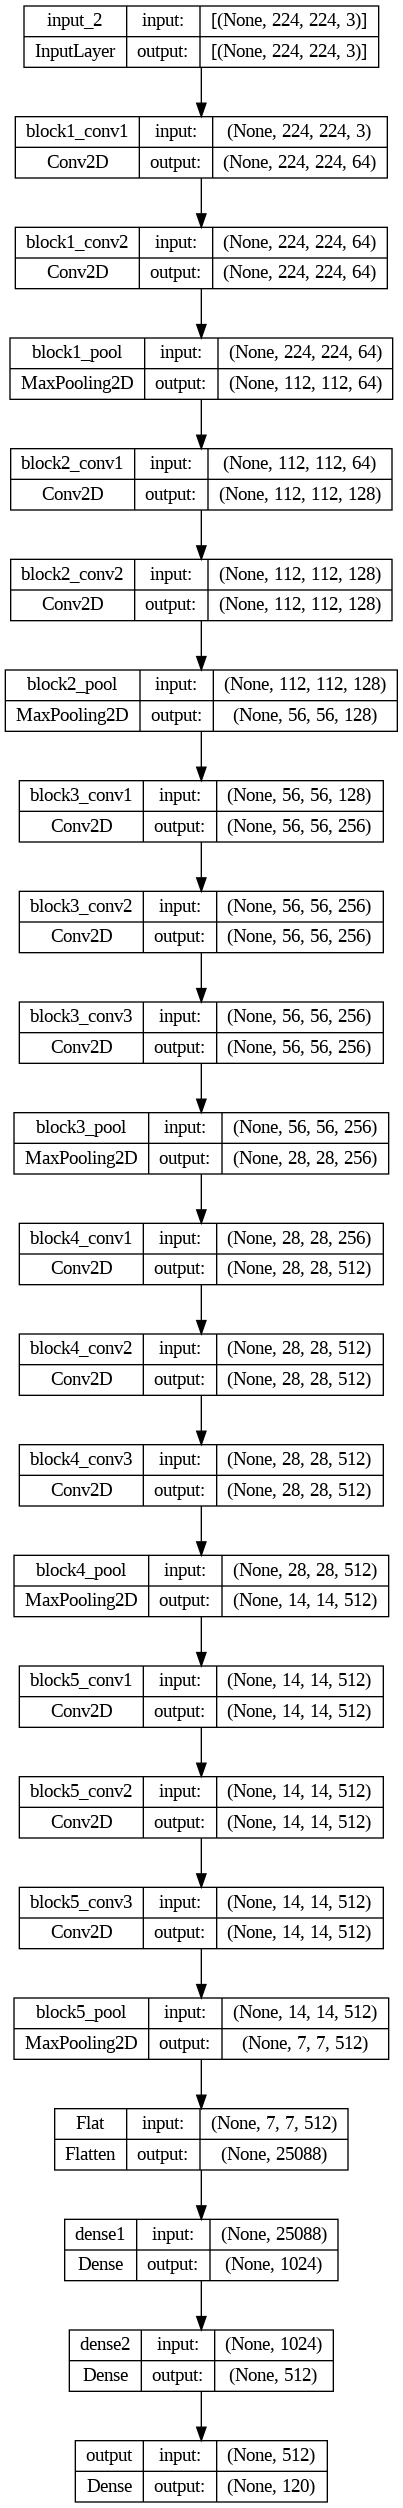

In [ ]:
tf.keras.utils.plot_model(final_model, show_layer_names=True, show_shapes=True)

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [ ]:
final_model.fit(train_idg, epochs=10, batch_size=batch_size, validation_data=val_idg)

Epoch 1/10
144/144 [==============================] - 61s 372ms/step - loss: 39.8726 - acc: 0.0122 - val_loss: 4.9229 - val_acc: 0.0108
Epoch 2/10
144/144 [==============================] - 44s 303ms/step - loss: 5.7939 - acc: 0.0249 - val_loss: 4.8118 - val_acc: 0.0284
Epoch 3/10
144/144 [==============================] - 44s 306ms/step - loss: 4.9560 - acc: 0.0330 - val_loss: 4.8488 - val_acc: 0.0245
Epoch 4/10
144/144 [==============================] - 48s 331ms/step - loss: 4.7822 - acc: 0.0388 - val_loss: 4.6870 - val_acc: 0.0284
Epoch 5/10
144/144 [==============================] - 44s 302ms/step - loss: 4.6191 - acc: 0.0486 - val_loss: 4.6628 - val_acc: 0.0499
Epoch 6/10
144/144 [==============================] - 44s 304ms/step - loss: 4.5015 - acc: 0.0648 - val_loss: 4.6558 - val_acc: 0.0499
Epoch 7/10
144/144 [==============================] - 44s 302ms/step - loss: 4.5030 - acc: 0.0678 - val_loss: 4.5889 - val_acc: 0.0470
Epoch 8/10
144/144 [==============================] - 

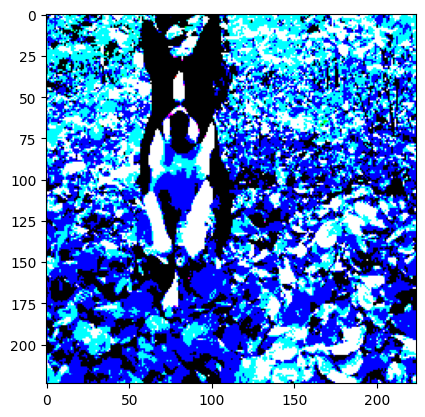

In [ ]:
plt.imshow(test_image[0])

In [ ]:
test_image.shape

(1, 224, 224, 3)

In [ ]:
np.argmax(final_model.predict(test_image)) # bernese_mountain_dog

1/1 [==============================] - 0s 78ms/step


11

In [ ]:
train_idg.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'